#### 计算 DLS-ADMM 调整后的网络特征图谱

In [5]:
import os
import sys
sys.path.append(r"../../")
import copy
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import random
import pandas as pd
# 自定义
from base_mods import *
from nodes.Lorenz import *
from utils.DLS import *
from connect.BA_scale_free import create_sf_jit, create_sf

In [6]:
def Lorenz_DLS(seed=0):
    np.random.seed(seed)
    random.seed(seed)

    N = 100
    dt = 0.01
    
    t = 0.

    # 节点参数
    params_nodes = {
        "sigma": 10.,
        "rho": 28.,
        "beta": 2.,
    } 
    # 模型变量的初始值
    x0 = np.random.rand(N)
    y0 = np.random.rand(N)
    z0 = np.random.rand(N)
    vars_nodes = np.vstack((x0, y0, z0))

    N_vars = 3  # 变量的数量

    # 拓扑结构
    degree = 4
    connM = create_sf_jit(n=N, n_init=degree+1, n_add=int(degree/2), seed=seed)

    # 权重
    w = np.random.uniform(0, 1, (N, N))
    
    # 初始化节点
    for i in range(100_00):
        I = np.zeros((N_vars, N))
        params_list = list(params_nodes.values())

        RK4(Lorenz_model, vars_nodes, t, dt, I, params_list)

        t += dt  # 时间前进

    # 初始化网络
    for i in range(200_00):
        vj_vi = vars_nodes[1]-np.expand_dims(vars_nodes[1], axis=1)   # pre减post
        Isyn = (w*connM*vj_vi).sum(axis=1)
        I = np.zeros((N_vars, N))
        I[0] += Isyn
        params_list = list(params_nodes.values())

        RK4(Lorenz_model, vars_nodes, t, dt, I, params_list)

        t += dt  # 时间前进

    # =================== 开始计算 ===================
    t = 0.

    for i in range(10_00):
        vj_vi = vars_nodes[1]-np.expand_dims(vars_nodes[1], axis=1)   # pre减post
        Isyn = (w*connM*vj_vi).sum(axis=1)
        I = np.zeros((N_vars, N))
        I[0] += Isyn
        params_list = list(params_nodes.values())

        RK4(Lorenz_model, vars_nodes, t, dt, I, params_list)

        # mem.append(vars_nodes[0].copy())

        t += dt  # 时间前进

    # return mem

    # 定义 DLS_ADMM 参数
    local = np.arange(N)            # 网络学习部位（全部学习）
    w_min = 0.                      # None
    w_max = 5.
    rho = 0.1
    alpha = 0.1

    P = np.full((len(local), N), alpha)
    z = np.zeros((len(local), N))
    mu = np.zeros((len(local), N))

    # 使用 DLS
    e_mems = []

    Tn = 1000_00
    for i in range(Tn):
        vj_vi = vars_nodes[1]-np.expand_dims(vars_nodes[1], axis=1)   # pre减post
        factor = connM*vj_vi
        Isyn = (w*factor).sum(axis=1)
        I = np.zeros((N_vars, N))
        I[0] += Isyn
        params_list = list(params_nodes.values())

        RK4(Lorenz_model, vars_nodes, t, dt, I, params_list)
        
        if i % 100 < 30:
            # 外部因素的输入值  (N_节点, N_节点/N_自定义)
            factor_dt = factor * dt  # (N_节点, N_节点/N_自定义)

            yMean = vars_nodes[0][local].mean()

            # 最小二乘法差值(N_节点,)
            error_input = vars_nodes[0] - yMean

            DLS_jit(w, factor_dt, error_input, local, P)

            update_admm(w, z, mu, rho, local, w_min, w_max)

        e_mem = vars_nodes[0].std()
        e_mems.append(e_mem)

        t += dt  # 时间前进

    return e_mems    

In [7]:
e_mems = Lorenz_DLS()

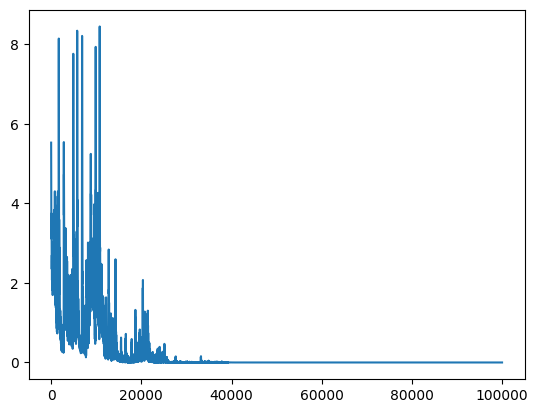

In [8]:
plt.plot(e_mems)
plt.show()